In [1]:
!pip install wordcloud

In [2]:
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.decomposition import TruncatedSVD

In [3]:
df = pd.read_csv('C:/Users/allen/Desktop/4523 Project/final_df.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71308 entries, 0 to 71307
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   job_id                      71308 non-null  int64  
 1   company_id                  71308 non-null  float64
 2   med_salary                  71308 non-null  float64
 3   remote_allowed              10273 non-null  float64
 4   company_size                69153 non-null  float64
 5   state                       71269 non-null  object 
 6   salary_id                   71308 non-null  float64
 7   industry_id                 71290 non-null  float64
 8   skill_abr                   71024 non-null  object 
 9   formatted_experience_level  54340 non-null  object 
 10  sponsored                   71308 non-null  int64  
 11  formatted_work_type         71308 non-null  object 
 12  title                       71308 non-null  object 
 13  application_type            713

In [5]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\allen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\allen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
def clean_text(text):
    text = text.lower()
    text = nltk.RegexpTokenizer(r"\w+").tokenize(text)
    text = [lemmatizer.lemmatize(word) for word in text if word not in stop_words]
    return " ".join(text)

In [7]:
df['cleaned_job_description'] = df['combined_description'].apply(clean_text)

In [8]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [9]:
custom_stop_words = [
    'status', 'state', 'limit', 'sexual', 'regard', 'customer', 'dental',
    'local', 'race', 'functional', 'national', 'environment', 'experience',
    'bachelor', 'job', 'identity', 'practice', 'including', 'external', 'www',
    'com', 'team', 'employer', 'without', 'salary', 'range', 'member', 'color',
     'http', 'york', 'cross', 'veteran', 'fast', 'employee', 'vision',
    'project', 'reasonable', 'opportunity', 'religion', 'orientation',
    'long', 'term', 'management', 'year', 'new', 'equal', 'applicant',
    'accommodation', 'paced', 'description', 'qualified', 'marital',
    'work', 'internal', 'gender','sex','e','g','time','disability',
    'strategy','maximum','eeo','solved','reflects','regardless','hour',
    'scale','area', 'group', 'code', 'usa', 'like', 'ca', 'pre', 
    'learn', 'nurse', 'point', 'home'
]

combined_stop_words = list(ENGLISH_STOP_WORDS) + custom_stop_words


In [10]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words=combined_stop_words) 
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_job_description'])

### Description Wordcloud(Use)

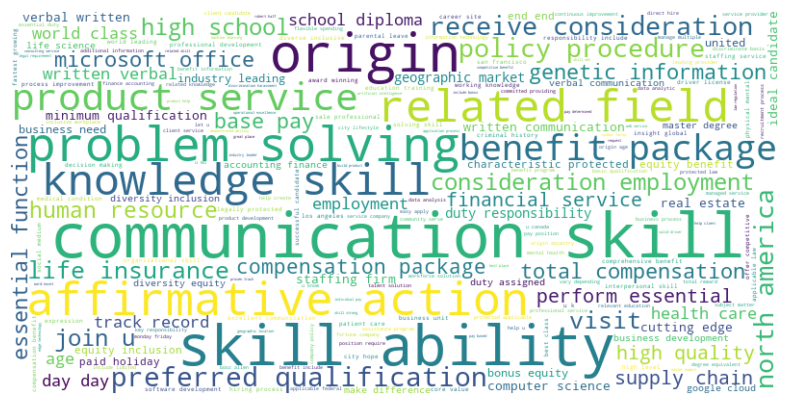

In [11]:
wordcloud = WordCloud(stopwords=combined_stop_words, background_color='white', width=800, height=400)
wordcloud.generate(' '.join(df['cleaned_job_description']))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Not Grouped Skill Appearence in Description(Use)

In [12]:
import re

skills_dic = {}

unique_skills = set(
    skill.strip().lower()
    for skills_list in df['skill_name'].dropna()
    for skill in skills_list.split(',')
)

for skill in unique_skills:
    skills_dic[skill] = df['skill_name'].str.contains(r'\b' + re.escape(skill) + r'\b', case=False, na=False).astype(int)


In [13]:
feature_names = tfidf_vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

skills_df = tfidf_df[tfidf_df.columns.intersection(skills_dic)]

skills_frequency = skills_df.sum().sort_values(ascending=False)
binary_skills_df = skills_df.gt(0).astype(int)

In [14]:
skills_frequency#The frequency of mentioned in description

design            2166.674710
engineering       1887.486552
training          1475.019725
marketing         1410.907398
research          1209.474761
education         1184.954220
finance           1138.956523
manufacturing     1076.636111
science           1027.615504
consulting         959.572488
production         932.320866
legal              788.836345
analyst            654.404052
administrative     593.396578
distribution       499.138718
advertising        314.123557
dtype: float64

### Random Forest Model

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np
from sklearn.cluster import KMeans

In [16]:
tfidf_vectorizer_rf = TfidfVectorizer(max_features=1000, stop_words=combined_stop_words) # Choose an appropriate number
X = tfidf_vectorizer_rf.fit_transform(df['cleaned_job_description'])

salary_threshold = np.percentile(df['med_salary'], 80) 
y = (df['med_salary'] >= salary_threshold).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

feature_importances = clf.feature_importances_
feature_names = tfidf_vectorizer.get_feature_names_out()

features = zip(feature_names, feature_importances)
sorted_features = sorted(features, key=lambda x: x[1], reverse=True)

print("Most indicative features for high salary:")
for feature, importance in sorted_features[:20]:  # Top 20 features
    print(f"{feature}: {importance}")

Most indicative features for high salary:
equity: 0.009909378102806765
cloud: 0.009152431623959787
google: 0.008113126502249433
architecture: 0.007784668342846729
form: 0.006666011476003506
pipeline: 0.006155999807646575
determined: 0.006152875533007421
director: 0.006030978845782365
platform: 0.0057859402486359224
development: 0.005691319261689598
base: 0.005671177167350011
strategic: 0.005648378677838929
note: 0.005278603393436462
publication: 0.005230177365666849
posting: 0.004994198529303951
leadership: 0.00482169466733825
build: 0.004696555189075653
technology: 0.004619592533182659
truly: 0.004591401007380805
target: 0.004482953152514654


### Text Clustering(Not use)

In [17]:
vectorizer = TfidfVectorizer(token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', stop_words=combined_stop_words, max_features=1000)

X_clustering = vectorizer.fit_transform(df['combined_description'])

svd = TruncatedSVD(n_components=50, random_state=42)
X_clustering_reduced = svd.fit_transform(X_clustering)

In [18]:
num_clusters = 5 

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_clustering_reduced)

df['cluster'] = kmeans.labels_

C:\Users\allen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [19]:
print(df[['combined_description', 'cluster']].head())
print(df['cluster'].value_counts())

                                combined_description  cluster
0  Overview\n\nHearingLife is a national hearing ...        4
1  Overview\n\nWho WE Are: \n\nHearingLife is a D...        4
2  descriptionTitle\n\n Looking for a great oppor...        2
3  descriptionTitle\n\n Looking for a great oppor...        2
4  descriptionTitle\n\n $2,000 Sign-on Bonus Guar...        2
2    31296
0    30365
4     4506
1     2806
3     2335
Name: cluster, dtype: int64


In [20]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def print_top_terms_per_cluster(feature_names, kmeans_model, n_terms=10):
    order_centroids = kmeans_model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()
    for i in range(num_clusters):
        print(f"Cluster {i}:")
        top_terms = [feature_names[ind] for ind in order_centroids[i, :n_terms]]
        print(", ".join(top_terms))

feature_names = vectorizer.get_feature_names_out()
print_top_terms_per_cluster(feature_names, kmeans, n_terms=10)

Cluster 0:
401k, ability, able, accordance, accounts, act, achieve, actively, account, accurate
Cluster 1:
abilities, 401k, according, accommodations, account, accurate, ability, administration, act, accuracy
Cluster 2:
401k, access, accounting, actions, acquisition, activities, additional, accuracy, advertising, analytical
Cluster 3:
able, 401k, abilities, according, accommodations, account, accuracy, accurate, act, addition
Cluster 4:
401k, accommodations, accordance, according, accounts, advisory, ad, achieve, actively, administration


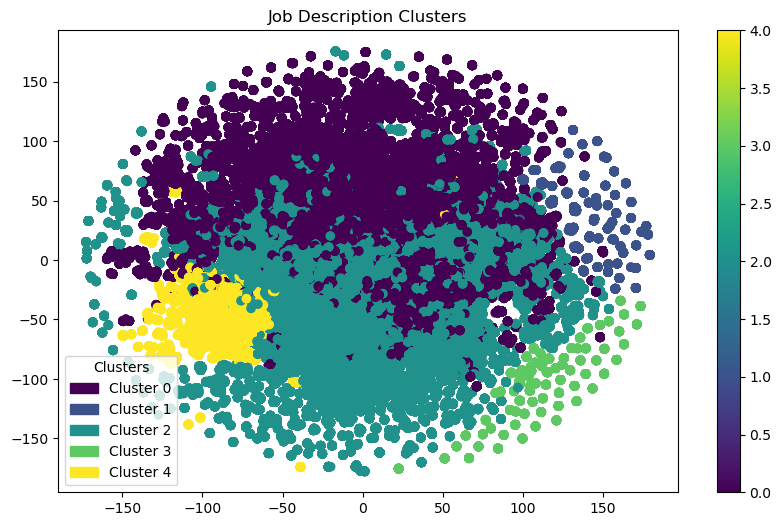

In [21]:
import matplotlib.pyplot as plt
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_clustering_reduced)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans.labels_, cmap='viridis')
plt.colorbar(scatter)
plt.title('Job Description Clusters')

unique_labels = np.unique(kmeans.labels_)
colors = [scatter.cmap(scatter.norm(label)) for label in unique_labels]

import matplotlib.patches as mpatches
handles = [mpatches.Patch(color=colors[i], label=f'Cluster {unique_labels[i]}') for i in range(len(unique_labels))]
plt.legend(handles=handles, title="Clusters")

plt.show()
